### Importing Libraries

In [2]:
!pip install catboost
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SequentialFeatureSelector
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 


In [30]:
import matplotlib.pyplot as plt

### Reading csv files of Testing and Training Data

In [3]:
train_dataframe = pd.read_csv('./train.csv', index_col='PassengerId')
test_dataframe = pd.read_csv('./test.csv', index_col='PassengerId')

# Dimensions and Preview
print('train_dataframe dimensions', train_dataframe.shape)
print('test_dataframe dimensions', test_dataframe.shape)
train_dataframe.head(10).style.background_gradient(cmap="Spectral")

train_dataframe dimensions (8693, 13)
test_dataframe dimensions (4277, 12)


,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.000000,False,109.000000,9.000000,25.000000,549.000000,44.000000,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.000000,True,43.000000,3576.000000,0.000000,6715.000000,49.000000,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.000000,False,0.000000,1283.000000,371.000000,3329.000000,193.000000,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.000000,False,303.000000,70.000000,151.000000,565.000000,2.000000,Willy Santantines,True
0005_01,Earth,False,F/0/P,PSO J318.5-22,44.000000,False,0.000000,483.000000,0.000000,291.000000,0.000000,Sandie Hinetthews,True
0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.000000,False,42.000000,1539.000000,3.000000,0.000000,0.000000,Billex Jacostaffey,True
0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.000000,False,0.000000,0.000000,0.000000,0.000000,nan,Candra Jacostaffey,True
0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.000000,False,0.000000,785.000000,17.000000,216.000000,0.000000,Andona Beston,True


#### Dropping Name
#### Replacing Transported column's value with 0 and 1, 0 means False, 1 means True

In [4]:
train_dataframe.drop('Name', axis=1, inplace=True)
test_dataframe.drop('Name', axis=1, inplace=True)

train_dataframe['Transported'].replace(False, 0, inplace=True)
train_dataframe['Transported'].replace(True, 1, inplace=True)

#### Splitting Cabin column into 4 columns, sperated by '/' and then dropping Cabin

In [5]:
train_dataframe[['deck','num', 'side']] = train_dataframe['Cabin'].str.split('/', expand=True)
test_dataframe[['deck','num', 'side']] = test_dataframe['Cabin'].str.split('/', expand=True)

train_dataframe.drop('Cabin', axis=1, inplace=True)
test_dataframe.drop('Cabin', axis=1, inplace=True)

#### Totalling the columns "RoomService", "FoodCourt", "ShopppingMall", "Spa", and "VRDeck" and making it into 1 column, i.e., Total_Expenditure

In [6]:
summingColumns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

train_dataframe['Total_Expenditure'] = train_dataframe[summingColumns].sum(axis=1)
test_dataframe['Total_Expenditure'] = test_dataframe[summingColumns].sum(axis=1)

#### Display of Train Dataframe after some preprocessing

In [7]:
train_dataframe.head(10).style.background_gradient(cmap="Spectral")

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,num,side,Total_Expenditure
PassengerId,,,,,,,,,,,,,,,
0001_01,Europa,False,TRAPPIST-1e,39.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,0,B,0,P,0.000000
0002_01,Earth,False,TRAPPIST-1e,24.000000,False,109.000000,9.000000,25.000000,549.000000,44.000000,1,F,0,S,736.000000
0003_01,Europa,False,TRAPPIST-1e,58.000000,True,43.000000,3576.000000,0.000000,6715.000000,49.000000,0,A,0,S,10383.000000
0003_02,Europa,False,TRAPPIST-1e,33.000000,False,0.000000,1283.000000,371.000000,3329.000000,193.000000,0,A,0,S,5176.000000
0004_01,Earth,False,TRAPPIST-1e,16.000000,False,303.000000,70.000000,151.000000,565.000000,2.000000,1,F,1,S,1091.000000
0005_01,Earth,False,PSO J318.5-22,44.000000,False,0.000000,483.000000,0.000000,291.000000,0.000000,1,F,0,P,774.000000
0006_01,Earth,False,TRAPPIST-1e,26.000000,False,42.000000,1539.000000,3.000000,0.000000,0.000000,1,F,2,S,1584.000000
0006_02,Earth,True,TRAPPIST-1e,28.000000,False,0.000000,0.000000,0.000000,0.000000,nan,1,G,0,S,0.000000
0007_01,Earth,False,TRAPPIST-1e,35.000000,False,0.000000,785.000000,17.000000,216.000000,0.000000,1,F,3,S,1018.000000


#### Display of Test Dataframe after some preprocessing

In [8]:
test_dataframe.head(10).style.background_gradient(cmap="Spectral")

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck,num,side,Total_Expenditure
PassengerId,,,,,,,,,,,,,,
0013_01,Earth,True,TRAPPIST-1e,27.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,G,3,S,0.000000
0018_01,Earth,False,TRAPPIST-1e,19.000000,False,0.000000,9.000000,0.000000,2823.000000,0.000000,F,4,S,2832.000000
0019_01,Europa,True,55 Cancri e,31.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,C,0,S,0.000000
0021_01,Europa,False,TRAPPIST-1e,38.000000,False,0.000000,6652.000000,0.000000,181.000000,585.000000,C,1,S,7418.000000
0023_01,Earth,False,TRAPPIST-1e,20.000000,False,10.000000,0.000000,635.000000,0.000000,0.000000,F,5,S,645.000000
0027_01,Earth,False,TRAPPIST-1e,31.000000,False,0.000000,1615.000000,263.000000,113.000000,60.000000,F,7,P,2051.000000
0029_01,Europa,True,55 Cancri e,21.000000,False,0.000000,nan,0.000000,0.000000,0.000000,B,2,P,0.000000
0032_01,Europa,True,TRAPPIST-1e,20.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,D,0,S,0.000000
0032_02,Europa,True,55 Cancri e,23.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,D,0,S,0.000000


#### Checking the train_dataframe and test_dataframe, if they contain null and if yes then how many columns contain null

In [9]:
train_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   HomePlanet         8492 non-null   object 
 1   CryoSleep          8476 non-null   object 
 2   Destination        8511 non-null   object 
 3   Age                8514 non-null   float64
 4   VIP                8490 non-null   object 
 5   RoomService        8512 non-null   float64
 6   FoodCourt          8510 non-null   float64
 7   ShoppingMall       8485 non-null   float64
 8   Spa                8510 non-null   float64
 9   VRDeck             8505 non-null   float64
 10  Transported        8693 non-null   int64  
 11  deck               8494 non-null   object 
 12  num                8494 non-null   object 
 13  side               8494 non-null   object 
 14  Total_Expenditure  8693 non-null   float64
dtypes: float64(7), int64(1), object(7)
memory usage: 1.1+ MB


In [10]:
train_dataframe.isna().sum().to_frame().style.background_gradient(cmap="inferno")

,0
HomePlanet,201
CryoSleep,217
Destination,182
Age,179
VIP,203
RoomService,181
FoodCourt,183
ShoppingMall,208
Spa,183
VRDeck,188


In [11]:
test_dataframe.isna().sum().to_frame().style.background_gradient(cmap="inferno")

,0
HomePlanet,87
CryoSleep,93
Destination,92
Age,91
VIP,93
RoomService,82
FoodCourt,106
ShoppingMall,98
Spa,101
VRDeck,80


In [12]:
nullColumns = train_dataframe.isnull().sum().sort_values(ascending=False)
nullColumns = list(nullColumns[nullColumns>1].index)
nullColumns

['CryoSleep',
 'ShoppingMall',
 'VIP',
 'HomePlanet',
 'deck',
 'num',
 'side',
 'VRDeck',
 'FoodCourt',
 'Spa',
 'Destination',
 'RoomService',
 'Age']

### Cleaning Data

#### Converting object type data columns into category type

In [13]:
object_cols = [col for col in train_dataframe.columns if train_dataframe[col].dtype == 'object' or train_dataframe[col].dtype == 'category']
numeric_cols = [col for col in train_dataframe.columns if train_dataframe[col].dtype == 'float64']
print(f'Numeric data type Columns: {numeric_cols}')
print(f'Object data type columns: {object_cols}')
train_dataframe[object_cols] = train_dataframe[object_cols].astype('category')
test_dataframe[object_cols] = test_dataframe[object_cols].astype('category')


Numeric data type Columns: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Total_Expenditure']
Object data type columns: ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'deck', 'num', 'side']


#### Float or numeric values are encoded (converted) from categorical values in objects or strings for use in classification.

## Many kaggle competition suggested to use this method with for better accuracy

In [14]:
ordinalEncoder = OrdinalEncoder()

encode_df = pd.concat([train_dataframe, test_dataframe])
encode_df[object_cols] = encode_df[object_cols].astype('category')
encode_df[object_cols] = ordinalEncoder.fit_transform(encode_df[object_cols])

del train_dataframe, test_dataframe

train_dataframe = encode_df.iloc[:8693, :]
test_dataframe = encode_df.iloc[8693: , :]

del encode_df



#### Removing Transported column from Test Dataframe

In [15]:
test_dataframe.drop('Transported', inplace=True, axis=1)

### Dataframe after Transported Dropped

In [16]:
test_dataframe.head(10).style.background_gradient(cmap="Spectral")

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck,num,side,Total_Expenditure
PassengerId,,,,,,,,,,,,,,
0013_01,0.000000,1.000000,2.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1117.000000,1.000000,0.000000
0018_01,0.000000,0.000000,2.000000,19.000000,0.000000,0.000000,9.000000,0.000000,2823.000000,0.000000,5.000000,1228.000000,1.000000,2832.000000
0019_01,1.000000,1.000000,0.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000
0021_01,1.000000,0.000000,2.000000,38.000000,0.000000,0.000000,6652.000000,0.000000,181.000000,585.000000,2.000000,1.000000,1.000000,7418.000000
0023_01,0.000000,0.000000,2.000000,20.000000,0.000000,10.000000,0.000000,635.000000,0.000000,0.000000,5.000000,1339.000000,1.000000,645.000000
0027_01,0.000000,0.000000,2.000000,31.000000,0.000000,0.000000,1615.000000,263.000000,113.000000,60.000000,5.000000,1561.000000,0.000000,2051.000000
0029_01,1.000000,1.000000,0.000000,21.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,1.000000,1006.000000,0.000000,0.000000
0032_01,1.000000,1.000000,2.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1.000000,0.000000
0032_02,1.000000,1.000000,0.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1.000000,0.000000


#### Missing columns are being replaced by the mean of that column

In [17]:
colTransformer = ColumnTransformer([("imp", SimpleImputer(strategy='mean'), nullColumns)])
train_dataframe[nullColumns] = colTransformer.fit_transform(train_dataframe[nullColumns])
test_dataframe[nullColumns] = colTransformer.fit_transform(test_dataframe[nullColumns])

## Training the models

#### Splitting the test and train in 70:30 respectively for training the model

In [18]:
X = train_dataframe.copy()
y = X.pop('Transported')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=40)

#### Implementing Catboost, unlike other models, it can't be imported btu can only be installed first

### To choose the best model, we purposely compare 4 models. then put to use in the last stage.
1. RandomForestClassifier
2. AdaBoostClassifier
3. XGBClassifier
4. CatBoostClassifier

#### Correctness score and cross validation, two metrics that measure the model's accuracy, will be used to assess the model's accuracy. We define cross validation and verbose using GridSearchCV.



In [19]:
def predict_and_acc(model, verbose=None):
    
    if verbose == None:
        model = model()
        model.fit(X_train, y_train)
        predict = model.predict(X_test)
        cvs = cross_val_score(model, X, y, cv=4)
        print(f'The accuracy score of {str(model)} is {float(accuracy_score(y_test, predict))}')
        print(f'The cross validation of {str(model)} is:{cvs} with mean of {cvs.mean()}')
    else:
        model = model(verbose=verbose)
        model.fit(X_train, y_train)
        predict = model.predict(X_test)
        cvs = cross_val_score(model, X, y, cv=4)
        print(f'The accuracy score of {str(model)} is {float(accuracy_score(y_test, predict))}')
        print(f'The cross validation of {str(model)} is:{cvs} with mean of {cvs.mean()}')

In [ ]:
predict_and_acc(RandomForestClassifier, None)

In [ ]:
predict_and_acc(AdaBoostClassifier)

In [ ]:
predict_and_acc(XGBClassifier)

In [ ]:
predict_and_acc(CatBoostClassifier, verbose=False)

In [ ]:
model_fs = CatBoostClassifier(verbose=False)
sf = SequentialFeatureSelector(model_fs, scoring='accuracy', direction = 'backward')
sf.fit(X,y)

In [25]:
best_features = list(sf.get_feature_names_out())
best_features

['CryoSleep',
 'RoomService',
 'Spa',
 'VRDeck',
 'deck',
 'side',
 'Total_Expenditure']

In [26]:
model = CatBoostClassifier(verbose=False, eval_metric='Accuracy')
model.fit(X[best_features], y)
prediction = model.predict(test_dataframe[best_features])

## Predictions 

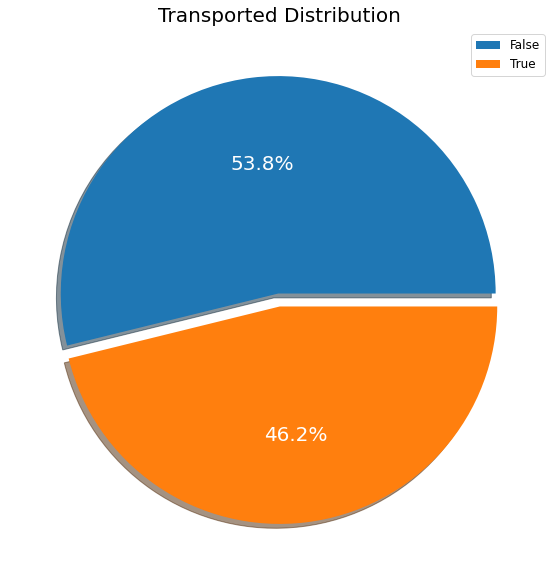

In [28]:


final = pd.DataFrame()
final.index = test_dataframe.index
final['Transported'] = prediction
final['Transported'].replace(0, False, inplace=True)
final['Transported'].replace(1, True, inplace=True)



plt.subplots(figsize=(25, 10))
plt.pie(final.Transported.value_counts(), shadow=True, explode=[.03,.03], autopct='%1.1f%%', textprops={'fontsize': 20, 'color': 'white'})
plt.title('Transported Distribution', size=20)
plt.legend(['False', 'True'], loc='best', fontsize=12)
plt.show()

In [29]:
final

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,True
...,...
9266_02,True
9269_01,False
9271_01,True


In [ ]:
final.to_csv('submission.csv')